In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from linecache import getline
from gurobipy import Model, GRB, quicksum
import math
import networkx

In [2]:
def parseNumVehicles(line):
    x = re.findall(r"No of trucks: [0-9]", line)
    return int(x[0][-1])

def parseForNum(line):
    x = re.findall(r"[0-9]+", line)
    return int(x[0])

def parseCoords(line):
    x = line.split()
    return [int(x[1]), int(x[2])]

def parseDemand(line):
    x = line.split()
    return [int(x[0]), int(x[1])]

### Parsing text file for the instance data

In [3]:
COORD_FLAG = False
DEMAND_FLAG = False
xc = []
yc = []
coords = []
q = {}
    
fh = open("E-n23-k3.txt",'r')
for i,line in enumerate(fh):
    if "CAPACITY" in line:
        Q = parseForNum(line)
    elif "COMMENT" in line:
        p = parseNumVehicles(line)
    elif "DIMENSION" in line:
        n = int(parseForNum(line)) - 1 # number of clients
    elif "NODE_COORD_SECTION" in line:
        COORD_FLAG = True
    elif "DEMAND_SECTION" in line:
        COORD_FLAG = False
        DEMAND_FLAG = True
    elif "DEPOT_SECTION" in line:
        DEMAND_FLAG = False
        print()
    elif COORD_FLAG:
        coord = parseCoords(line)
        xc.append(coord[0])
        yc.append(coord[1])
        coords.append(coord)
    elif DEMAND_FLAG:
        demand = parseDemand(line)
        q[demand[0]] = demand[1]
fh.close()

### Plotting instances

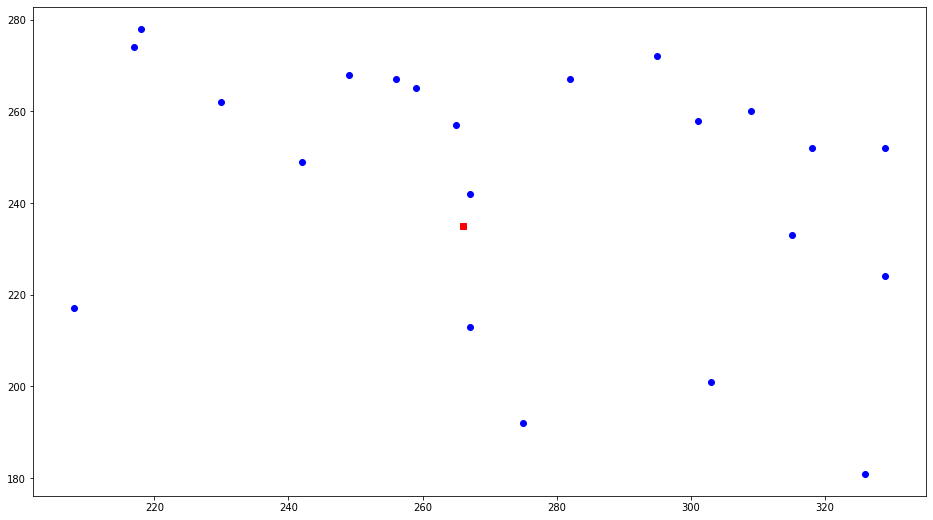

In [4]:
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

In [5]:
# N = [i for i in range(1, n+1)] # Number of clients
# V = [0] + N # Number of nodes (including depot)
# A = [(i, j) for i in V for j in V] 
# c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A} # cost

In [6]:
def solve(V,c,m,q,Q):
    """solve_vrp -- solve the vehicle routing problem.
       - start with assignment model (depot has a special status)
       - add cuts until all components of the graph are connected
    Parameters:
        - V: set/list of nodes in the graph
        - c[i,j]: cost for traversing edge (i,j)
        - m: number of vehicles available
        - q[i]: demand for customer i
        - Q: vehicle capacity
    Returns the optimum objective value and the list of edges used.
    """
    
    def addcut(cut_edges):
        """addcut: add constraint to eliminate infeasible solutions
        Parameters:
            - cut_edges: list of edges in the current solution, except connections to depot
        Returns True is a cut was added, False otherwise
        """
        G = networkx.Graph()
        G.add_edges_from(cut_edges)
        Components = networkx.connected_components(G)
        cut = False
        for S in Components:
            S_card = len(S)
            q_sum = sum(q[i] for i in S)
            NS = int(math.ceil(float(q_sum)/Q))
            S_edges = [(i,j) for i in S for j in S if i<j and (i,j) in cut_edges]
            if S_card >= 3 and (len(S_edges) >= S_card or NS > 1):
                add = model.addConstr(quicksum(x[i,j] for i in S for j in S if j > i) <= S_card-NS)
                model.update()
                cut = True
        return cut

    model = Model("vrp")
    x = {}
    for i in V:
        for j in V:
            if j > i and i == V[0]:       # depot
                x[i,j] = model.addVar(ub=2, vtype="I", name="x(%s,%s)"%(i,j))
            elif j > i:
                x[i,j] = model.addVar(ub=1, vtype="I", name="x(%s,%s)"%(i,j))
    model.update()

    model.addConstr(quicksum(x[V[0],j] for j in V[1:]) == 2*m, "DegreeDepot")
    for i in V[1:]:
        model.addConstr(quicksum(x[j,i] for j in V if j < i) +
                        quicksum(x[i,j] for j in V if j > i) == 2, "Degree(%s)"%i)

    model.setObjective(quicksum(c[i,j]*x[i,j] for i in V for j in V if j>i), GRB.MINIMIZE)

    model.update()
    # model.Params.OutputFlag = 0 # silent mode
    
    EPS = 1.e-6
    while True:
        model.optimize()
        edges = []
        active_arcs = []
        for a in x:
            i = a[0]
            j = a[1]
            if x[i,j].X > EPS:
                if i != V[0] and j != V[0]:
                    edges.append((i,j))
                    active_arcs.append(a)
        if addcut(edges) == False:
            break

    return model.ObjVal, edges, active_arcs

In [7]:
# distance: euclidean distance between (x1,y1) and (x2,y2)
def distance(x1, y1, x2, y2):
    return math.sqrt( ((x2 - x1)**2) + ((y2 - y1)**2 ))

# make_data: compute matrix distance based on euclidean distance"""
def make_data(n, x, y, q):
    c = {}
    V = range(1,n+1)
    for i in V:
        for j in V:
            if j > i:
                c[i, j] = distance(x[i], y[i], x[j], y[j])
                
    return V, c

In [8]:
V, c = make_data(n, xc, yc, q)
z, edges, active_arcs = solve(V, c, p, q, Q)
print("Optimal solution:", z)
print("Edges in the solution:")
print(sorted(edges))

Restricted license - for non-production use only - expires 2022-01-13
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 22 rows, 231 columns and 462 nonzeros
Model fingerprint: 0xcb001bb2
Variable types: 0 continuous, 231 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 2e+00]
  RHS range        [2e+00, 6e+00]
Found heuristic solution: objective 1307.3798166
Presolve time: 0.00s
Presolved: 22 rows, 231 columns, 462 nonzeros
Variable types: 0 continuous, 231 integer (210 binary)

Root relaxation: objective 5.025657e+02, 29 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  502.56566    0    6 1307.37982  502.56566  61.6%     -    0s
H    0     0              

H    0     0                     584.6211527  570.19592  2.47%     -    0s
H    0     0                     583.0314973  570.87371  2.09%     -    0s
*    0     0               0     581.2287718  581.22877  0.00%     -    0s

Cutting planes:
  Gomory: 2
  MIR: 4
  Zero half: 2

Explored 1 nodes (50 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 5: 581.229 583.031 584.621 ... 1307.38

Optimal solution found (tolerance 1.00e-04)
Best objective 5.812287718108e+02, best bound 5.812287718108e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 29 rows, 231 columns and 1195 nonzeros
Model fingerprint: 0x4c876c61
Variable types: 0 continuous, 231 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 2e+00]
  RHS range        [2e+00, 2e+01]


H    0     0                     618.1738514  570.69637  7.68%     -    0s
H    0     0                     615.9149841  570.69637  7.34%     -    0s
     0     0  582.99241    0   15  615.91498  582.99241  5.35%     -    0s
     0     0  582.99241    0   15  615.91498  582.99241  5.35%     -    0s
H    0     0                     587.8864515  582.99241  0.83%     -    0s
H    0     0                     585.7558688  582.99241  0.47%     -    0s
     0     0  582.99241    0   15  585.75587  582.99241  0.47%     -    0s
H    0     0                     585.5261792  582.99241  0.43%     -    0s
H    0     0                     585.1404052  582.99241  0.37%     -    0s
     0     0  584.20518    0   25  585.14041  584.20518  0.16%     -    0s
     0     0  584.20518    0   13  585.14041  584.20518  0.16%     -    0s
H    0     0                     584.6529843  584.20518  0.08%     -    0s
     0     0  584.21775    0   16  584.65298  584.21775  0.07%     -    0s

Cutting planes:
  Gomory


MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R37 by 1.000000000

Found heuristic solution: objective 1307.3798166
Presolve time: 0.00s
Presolved: 38 rows, 231 columns, 1934 nonzeros
Variable types: 0 continuous, 231 integer (210 binary)

Root relaxation: objective 5.752744e+02, 43 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  575.27437    0   20 1307.37982  575.27437  56.0%     -    0s
H    0     0                     704.7952531  575.27437  18.4%     -    0s
H    0     0                     630.7757380  575.27437  8.80%     -    0s
H    0     0                     603.8023720  575.27437  4.72%     -    0s
H    0     0                     598.5547532  575.42926  3.86%     -    0s
     0     0  584.33323    0   20  598.55475  584.33323  2.38%     -    0s
     0     0  

H    0     0                     588.6866842  586.03338  0.45%     -    0s
H    0     0                     588.1281429  586.03338  0.36%     -    0s
H    0     0                     587.5778631  586.03338  0.26%     -    0s

Cutting planes:
  Gomory: 1
  Clique: 1
  MIR: 8
  Zero half: 2

Explored 1 nodes (138 simplex iterations) in 0.06 seconds
Thread count was 12 (of 12 available processors)

Solution count 10: 587.578 588.128 588.687 ... 1307.38

Optimal solution found (tolerance 1.00e-04)
Best objective 5.875778631052e+02, best bound 5.875778631052e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 43 rows, 231 columns and 2407 nonzeros
Model fingerprint: 0xf81bc3b0
Variable types: 0 continuous, 231 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 2e+00]
  RHS range        [

H    0     0                     596.4937271  581.77540  2.47%     -    0s
     0     0  592.87040    0   28  596.49373  592.87040  0.61%     -    0s
     0     0  592.87040    0   19  596.49373  592.87040  0.61%     -    0s
H    0     0                     596.0349682  592.87040  0.53%     -    0s
     0     0  593.19093    0   20  596.03497  593.19093  0.48%     -    0s
H    0     0                     595.6248627  593.19093  0.41%     -    0s
H    0     0                     595.2041771  593.19093  0.34%     -    0s
H    0     0                     594.7940716  593.19093  0.27%     -    0s

Cutting planes:
  Gomory: 7
  Clique: 1
  MIR: 2
  Zero half: 4

Explored 1 nodes (117 simplex iterations) in 0.05 seconds
Thread count was 12 (of 12 available processors)

Solution count 10: 594.794 595.204 595.625 ... 912.595

Optimal solution found (tolerance 1.00e-04)
Best objective 5.947940715788e+02, best bound 5.947940715788e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (


Found heuristic solution: objective 1307.3798166
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 50 rows, 231 columns, 2898 nonzeros
Variable types: 0 continuous, 231 integer (210 binary)

Root relaxation: objective 5.817754e+02, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  581.77540    0   24 1307.37982  581.77540  55.5%     -    0s
H    0     0                     892.9560694  581.77540  34.8%     -    0s
H    0     0                     690.7952829  581.77540  15.8%     -    0s
H    0     0                     631.8348443  581.77540  7.92%     -    0s
H    0     0                     597.0440068  581.77540  2.56%     -    0s
     0     0  592.87040    0   28  597.04401  592.87040  0.70%     -    0s
     0     0  592.87040    0   19  597.04401  592.87040  0.70%     -    0s
H    0     0                     596.49372


Cutting planes:
  Gomory: 4
  Clique: 1
  MIR: 4
  Zero half: 9

Explored 1 nodes (128 simplex iterations) in 0.06 seconds
Thread count was 12 (of 12 available processors)

Solution count 8: 597.969 598.468 598.602 ... 1307.38

Optimal solution found (tolerance 1.00e-04)
Best objective 5.979694093822e+02, best bound 5.979694093822e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 57 rows, 231 columns and 3362 nonzeros
Model fingerprint: 0x1fa2df7b
Variable types: 0 continuous, 231 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 2e+01]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R56 by 1.000000000

Found heuristic solution: objective 1307.3798166
Presolve removed 1 ro

[266, 295, 301, 309, 217, 218, 282, 242, 230, 249, 256, 265, 267, 259, 315, 329, 318, 329, 267, 275, 303, 208, 326]
[235, 272, 258, 260, 274, 278, 267, 249, 262, 268, 267, 257, 242, 265, 233, 252, 252, 224, 213, 192, 201, 217, 181]


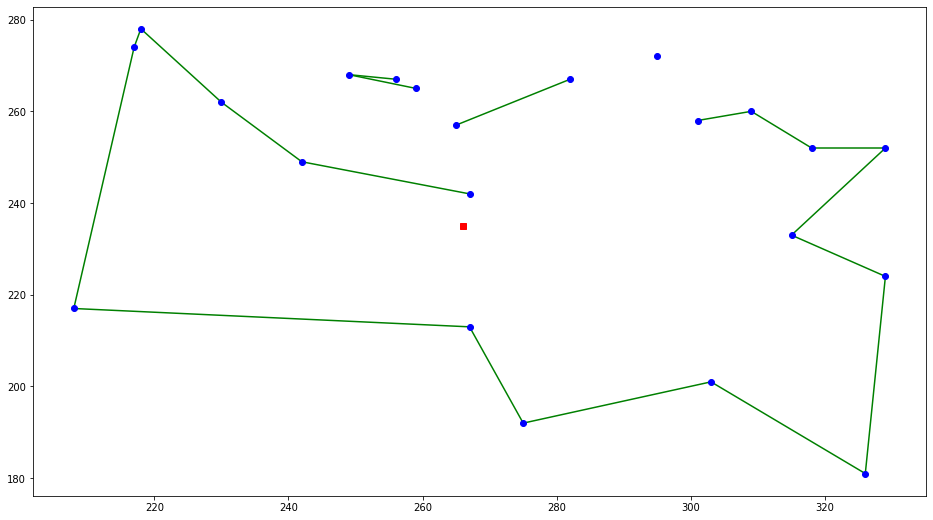

In [9]:
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')